<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [1]:
# system library
import os
import sys
import json

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import LearningCurve

# tree classifiers
from sklearn.tree import DecisionTreeClassifier

# linear classifiers
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# neighbors classifiers
from sklearn.neighbors import KNeighborsClassifier

# naive_bayes classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# ensemble classifiers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

from yellowbrick.style import set_palette
set_palette('bold')

<h6> Global parameters </h6>

In [27]:
n_iter = 10
scoring = 'f1_weighted'
random_state = 42

# test_n_splits = 9
test_n_splits = 3

model = AdaBoostClassifier(random_state=random_state, base_estimator=GaussianNB()) 
model_name = "GaussianNB AdaBoostClassifier"

learning_curve_flag = False
v_or_t_flag = "TST"
cmap = plt.cm.Greens
color = "green"

<h6> Datasets loading </h6>

In [3]:
X_train = pd.read_csv('../../data/fma_metadata/X_train_merged.csv', index_col=0)
X_test = pd.read_csv('../../data/fma_metadata/X_test.csv', index_col=0)

y_train = pd.read_csv('../../data/fma_metadata/y_train_merged.csv', index_col=0)
y_test = pd.read_csv('../../data/fma_metadata/y_test.csv', index_col=0)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

X_train_vt = pd.read_csv('../../data/fma_metadata/X_train_merged_vt.csv', index_col=0)
X_test_vt = pd.read_csv('../../data/fma_metadata/X_test_vt.csv', index_col=0)

print(X_train_vt.shape, X_test_vt.shape)
print(y_train.shape, y_test.shape)

(92834, 55) (10874, 55)
(92834, 1) (10874, 1)
(92834, 28) (10874, 28)
(92834, 1) (10874, 1)


<h6>Continous, categorical/ordinal column retrieval</h6>

In [4]:
numeric_columns = []  # continous variables
for column_name in X_train.columns:
    if ("track_genre_top" not in column_name) and  \
          ("track_date_created_year" not in column_name) and \
            ("track_date_created_season" not in column_name):
                numeric_columns.append(column_name)
print("numeric_columns", len(numeric_columns))

numeric_columns 37


In [5]:
categoric_columns = []  # ordinal or categorical variables
for column_name in X_train.columns:
    if ("track_genre_top" in column_name) or  \
          ("track_date_created_year" in column_name) or \
            ("track_date_created_season" in column_name):
                categoric_columns.append(column_name)
print("categoric_columns", len(categoric_columns))

categoric_columns 18


In [6]:
numeric_columns_vt = list(set(numeric_columns).intersection(set(X_train_vt.columns)))
print("numeric_columns_vt", len(numeric_columns_vt))

numeric_columns_vt 15


In [7]:
categoric_columns_vt = list(set(categoric_columns).intersection(set(X_train_vt.columns)))
print("categoric_columns_vt", len(categoric_columns_vt))

categoric_columns_vt 13


<h6>Define current (filtered) train and test</h6>

In [8]:
X_tr = X_train.copy()
y_tr = y_train.copy()
X_ts = X_test.copy()
y_ts = y_test.copy()

X_tr_vt = X_train_vt.copy()
X_ts_vt = X_test_vt.copy()

print(X_tr.shape, X_ts.shape, X_tr_vt.shape, X_ts_vt.shape)
print(y_tr.shape, y_ts.shape)

(92834, 55) (10874, 55) (92834, 28) (10874, 28)
(92834, 1) (10874, 1)


<h1>RandomForestClassifier (baseline classifier)</h1>

In [9]:
def model_baseline_classification(X_tr, y_tr, X_ts, y_ts):
    fitted_model = model.fit(X_tr, y_tr.values.ravel())
    y_pred = model.predict(X_ts)
    
    print(confusion_matrix(y_ts, y_pred))
    print(classification_report(y_ts, y_pred))
    
    try:
        features_importance = sorted(zip(X_tr.columns, fitted_model.feature_importances_),reverse=True)
        # print(features_importance)
    except:
        pass
    
    try:
        features_importance = sorted(zip(X_tr.columns, fitted_model.coef_),reverse=True)
        # print(features_importance)
    except:
        pass

<h6>All features (categorica, ordinal and continous)</h6>

In [10]:
model_baseline_classification(X_train, 
                              y_train, 
                              X_test, 
                              y_test)

[[9266  528]
 [1029   51]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      9794
           1       0.09      0.05      0.06      1080

    accuracy                           0.86     10874
   macro avg       0.49      0.50      0.49     10874
weighted avg       0.82      0.86      0.84     10874



<h6>Only continous variables</h6>

In [11]:
model_baseline_classification(X_train[numeric_columns], 
                              y_train, 
                              X_test[numeric_columns], 
                              y_test)

[[8729 1065]
 [ 956  124]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      9794
           1       0.10      0.11      0.11      1080

    accuracy                           0.81     10874
   macro avg       0.50      0.50      0.50     10874
weighted avg       0.82      0.81      0.82     10874



<h6>Only categorical or ordinal variables</h6>

In [12]:
model_baseline_classification(X_train[categoric_columns], 
                              y_train, 
                              X_test[categoric_columns], 
                              y_test)

[[7043 2751]
 [1028   52]]
              precision    recall  f1-score   support

           0       0.87      0.72      0.79      9794
           1       0.02      0.05      0.03      1080

    accuracy                           0.65     10874
   macro avg       0.45      0.38      0.41     10874
weighted avg       0.79      0.65      0.71     10874



<h2> Tuned AdaBoost </h2>
Boosting is a general ensemble method that creates a strong classifier from a number of weak
classifiers. This is done by building a model from the training data, then creating a second
model that attempts to correct the errors from the first model. Models are added until the
training set is predicted perfectly or a maximum number of models are added. AdaBoost was
the first really successful boosting algorithm developed for binary classification.

The most suited and therefore most common algorithm used with AdaBoost are decision trees
with one level. Because these trees are so short and only contain one decision for classification
they are often called decision stumps. However, any weak model (models that achieve accuracy just above random chance on a classification problem) can be used.

<h6>Classification process</h6>
Each instance in the training dataset is weighted. The initial weight is set to:
\begin{equation}
weight(x_{i}) = 1/N
\end{equation}
where $x_{i}$ is a record and n in the total number of records.

The a weak classifier (decision stump) is prepared on the training data using the weighted samples.
Only binary (two-class) classification problems are supported, so each decision stump makes one
decision on one input variable and outputs a +1.0 or -1.0 value for the first or second class value.
The misclassification rate is calculated as:
\begin{equation}
errorrate = N - correct / N
\end{equation}

This is modified to use the weighting of the training instances:
\begin{equation}
errorrate = \dfrac{\sum_{i=1}^{N} w_{i}perror_{i}}{\sum_{i=1}^{N} w_{i}}
\end{equation}
Which is the weighted sum of the misclassification rate, where $w_{i}$ is the weight for training
instance i and $perror_{i}$ is the prediction error for training instance i which is 1 if misclassified
and 0 if correctly classified.

A stage value is calculated for the trained model which provides a weighting for any predictions
that the model makes. The stage value for a trained model is calculated as follows:
\begin{equation}
stage = In(\dfrac{1 - error_rate}{error_rate})
\end{equation}
where stage is the stage value used to weight predictions from the model. The effect of the **stage weight
is that more accurate models have more weight or contribution to the final prediction**. 

The **training weights are updated giving more weight to incorrectly predicted instances**, and less
weight to correctly predicted instances. For example, the weight of one training instance ($w_{i}$) is
updated using:
\begin{equation}
w_{i} = w_{i}*e^{stage*perror}
\end{equation}
This has the effect of not changing the weight if the training instance was classified
correctly and making the weight slightly larger if the weak learner misclassified the instance.

Predictions are made by calculating the **weighted average** of the weak classifiers. For a new input
instance, each weak learner calculates a predicted value as either +1.0 or -1.0. The predicted
values are weighted **by each weak learners stage value**. The prediction for the ensemble model is
taken as a the sum of the weighted predictions:
- If the sum is positive, then the first class is predicted, 
- if negative the second class is predicted.

For example, 5 weak classifiers may predict the values 1.0, 1.0, -1.0, 1.0, -1.0. From a
majority vote, it looks like the model will predict a value of 1.0 or the first class. These same 5
weak classifiers may have the stage values 0.2, 0.5, 0.8, 0.2 and 0.9 respectively. Calculating
the weighted sum of these predictions results in an output of -0.8, which would be an ensemble
prediction of -1.0 or the second class.

**Default parameters**:
- base_estimator=None,
- n_estimators=range(50, 501, 50) + [25, 1000], 
- learning_rate=np.arange(0.05, 1.1, 0.05)
- algorithm='SAMME.R'
- random_state=None

**Tuned parameters**:
- random_state=42
- n_estimators=stumb classifier
- learning_rate=1.0

In [13]:
def model_grid(X_tr):
    grid = dict()
    grid['model__n_estimators'] = list(range(50, 501, 50)) + [25, 1000]
    grid['model__learning_rate'] = list(np.arange(0.05, 1.1, 0.05))
    return grid

In [14]:
# PLOT FUNCTIONS
def plot_roc_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_roc(y_ts, y_prob)
    plt.title("%s\'s %s ROC curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_precision_recall_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_precision_recall(y_ts, y_prob)
    plt.title("%s\'s %s Precision-Recall curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_cumulative_gain_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_cumulative_gain(y_ts, y_prob)
    plt.title("%s\'s %s Cumulative Gains curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_lift_curve_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_lift_curve(y_ts, y_prob)
    plt.title("%s\'s %s Lift curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_confusion_matrix(cm, classes, normalize):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("%s\'s %s classification report" % (model_name, v_or_t_flag.upper()))
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_classification_report(y_ts, y_pred):
    model_report = classification_report(y_ts, 
                                       y_pred,
                                       # target_names=['Studio Recording', 'Live Recording'],
                                       output_dict=True)
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    sns.heatmap(model_r, annot=True, cmap=cmap, cbar=False)
    plt.title("%s\'s %s confusion matrix" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_decision_boundary(X_tr, y_tr, scaler, model):
    try:
        pca = PCA(n_components=2)
        best_visualisation_scaler = StandardScaler()
        scaled_X_tr = best_visualisation_scaler.fit_transform(X_tr)
        X = pca.fit_transform(scaled_X_tr)
        # X = pca.fit_transform(X_tr)
        y = y_tr.values.ravel()

        model.fit(X, y)
        plt.figure(figsize=(8, 5))
        fig = plot_decision_regions(X=X, y=y, clf=model, legend=2)
        plt.xlabel("PCA component 1")
        plt.ylabel("PCA component 2")
        plt.title("%s's %s decision boundary" % (model_name, v_or_t_flag))
        plt.legend(loc='best')
        plt.grid(False)
        plt.show()
    except ValueError:
        return

def spot_errors(test_label, test_pred):  
    spot_errors = []
    label_errors = []
    for i in range(len(test_label)):
        if test_label[i] != test_pred[i]:
            spot_errors.append('darkred')
            label_errors.append("wrong prediction")
        else:
            spot_errors.append('darkgray')
            label_errors.append("correct prediction")
    return spot_errors, label_errors

def classification_visualizer(test_set, test_label, test_pred):
    test_label = test_label.values
    
    f, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,8))
    errors, label_errors = spot_errors(test_label, test_pred)
    labels = [test_label, test_pred, errors]
    titles = ['True Labels', 'Predicted Labels', 'Misclassifications']
    
    for i in range(0, 3):
        axs[i].scatter(test_set[missclassif_column_name1], test_set[missclassif_column_name2], c=labels[i], cmap='cividis')
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(missclassif_column_name1, fontdict={'fontsize': 'large'})
        axs[i].set_ylabel(missclassif_column_name2, fontdict={'fontsize': 'large'})
        
    plt.suptitle('Visualization of the ' + model_name + ' classifier on the %s' % v_or_t_flag)
    plt.show()
    

def error_visualizer(test_set, test_label, test_pred, column_name1, column_name2):
    test_label = test_label.values
    errors, label_errors = spot_errors(test_label, test_pred)
    
    palette = ['darkgray', 'darkred']
    if errors[0] == 'darkred':
        palette = ['darkred', 'darkgray']
    
    fig = plt.figure(figsize=(5, 6))
    sns.scatterplot(x=test_set[column_name1], y=test_set[column_name2], hue=label_errors, palette=palette)
    plt.title('%s\'s %s misclassifications' % (model_name, v_or_t_flag))
    plt.xlabel(column_name1)
    plt.ylabel(column_name2)

    plt.legend()
    plt.show()
    
def plot_learning_curve(X_tr, y_tr, model, v_or_t_flag):
    second_score = ""
    if v_or_t_flag == 'VAL':
        cv = StratifiedKFold(n_splits=validation_n_splits)
        second_score = "Validation score"
    else:
        cv = StratifiedKFold(n_splits=test_n_splits)
        second_score = "Test score"
    sizes = np.linspace(0.3, 1.0, 10)
    plt.figure(figsize=(8, 5))
    visualizer = LearningCurve(model, cv=cv, scoring=scoring, train_sizes=sizes, 
                                                                       n_jobs=-1, random_state=random_state)

    visualizer.fit(X_tr, y_tr.values.ravel())    
    # visualizer.ax.get_lines()[1].set_label(second_score)
    visualizer.show() 

In [15]:
def get_best_features_grid_cv(X_tr, y_tr, results, key):
    
    if key == 'anova':
        best_k = results.best_params_['anova__k']
        select_k_best = SelectKBest(score_func=f_classif, k=best_k)
        fit = select_k_best.fit(X_tr, y_tr.values.ravel())
        df_scores = pd.DataFrame(fit.scores_)
        df_columns = pd.DataFrame(X_tr.columns)
    elif key == 'rfe':
        best_k = results.best_params_['rfe__n_features_to_select']
        estimator = results.best_params_['rfe__estimator']
        select_rfe = RFE(estimator=estimator, n_features_to_select=best_k)  # best_k=estimator
        fit = select_rfe.fit(X_tr, y_tr.values.ravel())
        df_scores = pd.DataFrame(fit.ranking_)
    else:
        print("wrong key=%s" % key)
        sys.exit(-1)
  
    df_columns = pd.DataFrame(X_tr.columns)
    feature_scores = pd.concat([df_columns, df_scores],axis=1) # concatenate dataframes
    feature_scores.columns = ['features','scores']  # name output columns
    feature_scores = feature_scores[feature_scores['scores'] != 0]  # keeping only non-zero scoring features

    # plot feature importance
    fig = plt.figure(figsize=(8, 10))
    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = feature_scores.sort_values('scores', ascending=False).iloc[:best_k]
    sns.barplot(y='features', x='scores', data=feature_scores, color=color,
                                                            order=ordered_k_feature_scores.features)
    plt.grid(False)
    plt.title("%s's %s feature importance using %s" % (model_name, v_or_t_flag,  key.upper()))
    plt.show()

    # retrieve best features 
    # best_features = [column[0] for column in zip(X_tr.columns, select_k_best.get_support()) if column[1]]
    best_features = list(ordered_k_feature_scores.features)
    best_features_scores = list(ordered_k_feature_scores.scores)

    return best_features, best_features_scores

In [16]:
def get_feature_importances_or_coef(X_tr, y_tr, tuned_model):

    try:
        df_scores = pd.DataFrame(tuned_model.feature_importances_)
        best_k = tuned_model.n_features_
    except:
        try:
            df_scores = pd.DataFrame(tuned_model.coef_)

            best_k = len([x for x in list(df_scores.values)])
        except:
            print("Wrong curr_model's retrieval feature importance")
            sys.exit(-1)

    df_columns = pd.DataFrame(X_tr.columns)   
    feature_scores = pd.concat([df_columns, df_scores], axis=1) # concatenate dataframes
    feature_scores.columns = ['features','scores']  # name output columns
    feature_scores = feature_scores[feature_scores['scores'] != 0]  # keeping only non-zero scoring features

    # plot feature importance
    fig = plt.figure(figsize=(8, 10))
    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = feature_scores.sort_values('scores', ascending=False).iloc[:best_k]
    sns.barplot(y='features', x='scores', data=feature_scores, color=color,
                                                            order=ordered_k_feature_scores.features)
    plt.grid(False)
    plt.title("%s's %s feature importance" % (model_name, v_or_t_flag))
    plt.show()

    # retrieve best features 
    # best_features = [column[0] for column in zip(X_tr.columns, select_k_best.get_support()) if column[1]]
    best_features = list(ordered_k_feature_scores.features)
    best_features_scores = list(ordered_k_feature_scores.scores)


    return best_features, best_features_scores

In [17]:
def get_tuned_model(X_tr, y_tr, params):
    
    X_tr_curr = X_tr.copy()
    
    model_params = list(model_grid(X_tr_curr).keys())
    try:
        n_bins = params['preprocessor__numeric__discretizer__n_bins'] 
        strategy = params['preprocessor__numeric__discretizer__strategy']
        encode = params['preprocessor__numeric__discretizer__encode']
        discretizer = KBinsDiscretizer(encode=encode, n_bins=n_bins, strategy=strategy)
        # scale data
        X_tr_curr = discretizer.fit_transform(X_tr_curr.values)
    except KeyError:
        pass

    try:
        scaler = params['preprocessor__numeric__discretizer__scaler']
        # scale data
        X_tr_curr = scaler.fit_transform(X_tr_curr.values)
    except KeyError:
        pass
    
    # retrieve best hyperameters
    tmp_model_hyperparameters = dict((k, params[k]) for k in model_params if k in params)
    model_hyperparameters = {}
    for key, value in tmp_model_hyperparameters.items():
        key = key.split('model__')[1].replace("'", "")
        model_hyperparameters[key] = value
        
    tuned_model =  model.set_params(**model_hyperparameters)
    tuned_model.fit(X_tr_curr, y_tr.values.ravel())
    
    plot_decision_boundary(X_tr_curr, y_tr, MinMaxScaler(), tuned_model)  # passing random scaler
    
    if learning_curve_flag:
        plot_learning_curve(curr_X_tr_vt, y_tr, tuned_model, v_or_t_flag)
    
    return tuned_model

In [18]:
def grid_search(X_tr, y_tr, X_ts, y_ts, numeric_features, categorical_features, discretizer_flag, 
                                                            scaler_flag, feature_filter_key, feature_flag):
    
    # define the evaluation method
    cv = StratifiedKFold(n_splits=test_n_splits)

    # construct the pipeline to evaluate
    # scaler = RobustScaler()
    grid=model_grid(X_tr)
    steps = [('model', model)]
        
    if feature_filter_key == 'anova':
        anova = SelectKBest(score_func=f_classif)
        steps.insert(0, ('anova', anova))
        grid['anova__k'] = [i+1 for i in range(X_tr.shape[1])]
    elif feature_filter_key == 'rfe':
        rfe = RFE(estimator=DecisionTreeClassifier())
        steps.insert(0, ('rfe', rfe))
        grid['rfe__estimator'] = [DecisionTreeClassifier(), LogisticRegression(max_iter=10000)]
        grid['rfe__n_features_to_select'] = [i+1 for i in range(X_tr.shape[1])]
    
    # construct feature type's column transformer
    numeric_steps = []
    if scaler_flag:      # continous variable normalisation/standardisation
        numeric_steps.insert(0, ('scaler', None))
        grid['preprocessor__numeric__scaler'] = [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler()]
                      
    if discretizer_flag:  # continous variable binning
        numeric_steps.insert(0, ('discretizer', KBinsDiscretizer(encode='ordinal')))  # ordinal bins
        grid['preprocessor__numeric__discretizer__n_bins'] = list(range(2, 11))
        grid['preprocessor__numeric__discretizer__strategy'] = ['uniform', 'quantile', 'kmeans']
        
    numeric_transformer = None
    if len(numeric_steps) > 0:
        numeric_transformer = Pipeline(steps=numeric_steps)
        preprocessor = ColumnTransformer(
        transformers=[('numeric', numeric_transformer, numeric_features)])
        # add numeric ColumnTransformer to global Pipeline
        steps.insert(0, ('preprocessor', preprocessor))
        
    # define the pipeline to evaluate
    pipeline = Pipeline(steps=steps)
    
    # define the grid search
    # search = GridSearchCV(pipeline, grid, scoring='f1_weighted', n_jobs=-1, cv=cv, verbose=2)
    search = RandomizedSearchCV(pipeline, grid, scoring=scoring, n_jobs=-1, 
                                n_iter=n_iter, cv=cv, verbose=2, refit=scoring, random_state=random_state)
    
    # perform the search
    results = search.fit(X_tr, y_tr.values.ravel())
    
    # summarize best
    score = results.best_score_
    params = results.best_params_
    print('Best Mean F1_weighted: %.3f ' % score)
    print('Best Config: %s ' % params)
    
    # perform classification (linear model doesn't predict an integer value => no predict_proba)
    y_pred = search.predict(X_ts)
    y_prob = search.predict_proba(X_ts)
    
    best_features, best_features_scores = [], []
    if feature_filter_key != "":
        best_features, best_features_scores = get_best_features_grid_cv(X_tr, y_tr, results, feature_filter_key)
        X_tr = X_tr[best_features]
    
    # retrieve the tuned model
    tuned_model = get_tuned_model(X_tr, y_tr, params)
    if tuned_model !=  pipeline['model']:
        print("Difference in tuned model and pipeline")
        print("tuned_model", tuned_model)
        print("pipe", pipeline['model'])
        # print("estimator", results.estimator)
        sys.exit(-1)
    
    # plots
    if feature_flag and (feature_filter_key == ""):
        best_features, best_features_scores = get_feature_importances_or_coef(X_tr, y_tr, tuned_model)
    elif (feature_flag) and (feature_filter_key != ""):
        _ , _ = get_feature_importances_or_coef(X_tr, y_tr, tuned_model)
 
    cm = confusion_matrix(y_ts, y_pred)
    plot_confusion_matrix(cm, results.classes_, True)
    plot_classification_report(y_ts, y_pred)
    
    plot_roc_curve(y_ts, y_prob)
    plot_precision_recall_curve(y_ts, y_prob)
    plot_cumulative_gain_curve(y_ts, y_prob)
    plot_lift_curve_curve(y_ts, y_prob)
    
    # plot_decision_boundary(X_tr, y_tr, MinMaxScaler(), tuned_model)  # passing random scaler
    # plot_learning_curve(X_tr, y_tr, tuned_model)
    # error_visualizer(not_scale_X_ts, y_ts, y_pred, 'chroma_cens_02', 'track_duration')
    
    return params, tuned_model, y_pred, y_prob, best_features, best_features_scores

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.854 
Best Config: {'preprocessor__numeric__scaler': MinMaxScaler(), 'model__n_estimators': 300, 'model__learning_rate': 0.05} 


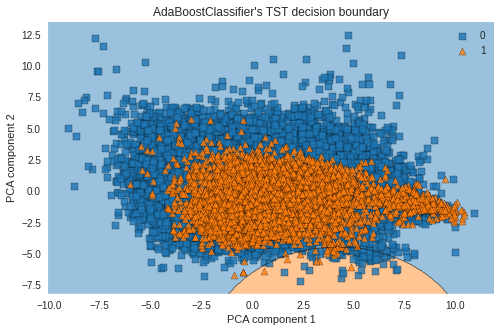

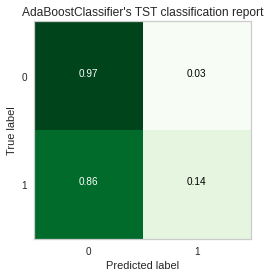

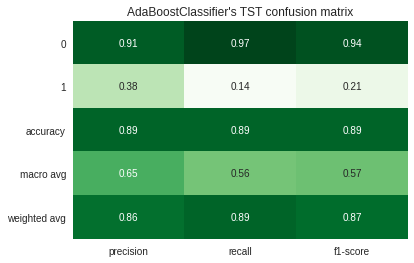

<Figure size 576x360 with 0 Axes>

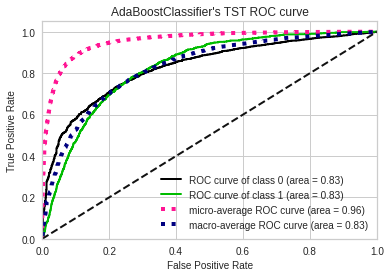

<Figure size 576x360 with 0 Axes>

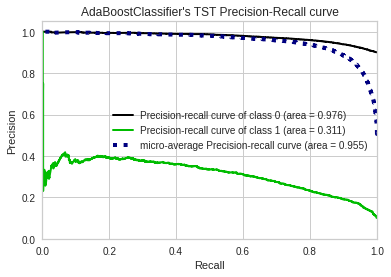

<Figure size 576x360 with 0 Axes>

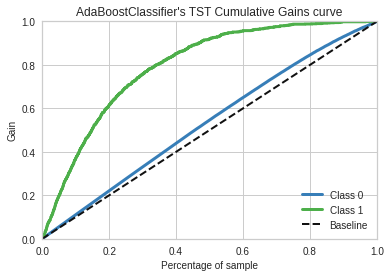

<Figure size 576x360 with 0 Axes>

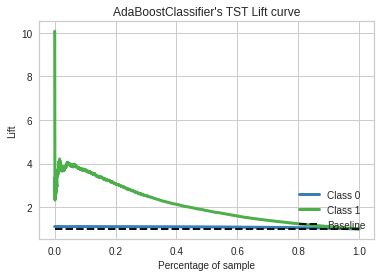

In [19]:
params_tst, tuned_model_tst, y_pred_tst, y_prob_tst, best_features, best_features_scores = \
                                                    grid_search(X_tr=X_tr, 
                                                                y_tr=y_tr,
                                                                X_ts=X_ts, 
                                                                y_ts=y_ts,
                                                                numeric_features=numeric_columns, 
                                                                categorical_features=categoric_columns, 
                                                                discretizer_flag=False,
                                                                scaler_flag=True, 
                                                                feature_filter_key="", 
                                                                feature_flag=False)

<font color="red"> <h1> Dimensionality reduction</h1></font>

Dimensionality reduction refers to techniques that reduce the number of input variables in a
dataset. More input features often make a predictive modeling task more challenging to model,
more generally referred to as the **curse of dimensionality**.

Dimensionality reduction methods include:
- feature selection: use scoring or statistical methods to select which features to keep and which features to delete:
    - **Wrapper methods**, wrap a machine learning model, fitting and evaluating the model with different subsets 
      input features and selecting the subset the results in the best model performance. (i.e. RFE);
    - **Filter methods** use scoring methods between the feature and the target variable, to select a
      subset of input features that are most predictive (i.e. Pearson’s correlation or Chi-Squared test).
- linear algebra methods:
    - **Matrix Factorization**: feature matrix (i.e. covariance matrix) can  be ranked and a subset of those parts can       be selected that best captures the salient structure of thematrix that can be used to represent the dataset.       (i.e. PCA);
- projection methods / manifold learning and are used to create a low-dimensional projection of high-dimensional data, whilst best preserving the salient structure or relationships in the data (i.e. SOM);
- autoencoders: A nueral network model is used that seeks to compress the data flow to a bottleneck layer with far fewer dimensions than the original input data. The part of the model prior to and including the bottleneck is referred to as the encoder, and the part of the model that reads the bottleneck output and reconstructs the input is called the decoder.

<u>Typically, linear algebra and manifold learning methods
assume that all input features have the same scale or distribution. This suggests that it is
good practice to either normalize or standardize data prior to using these methods.</u>

<b><font color="green"> 
For our feature selection process we decided to first use the Pearson Correlation Method to remove highly correlated features (see Features_Data_Understandind.ipynb);
Since data dimensionality was still high, we evaluate three different roads:
- Univariate Method, using SelectKBest with the ANOVA F-test, since our continous variables are almost alway normal distributed, while our classification target is categorical;
- Feature Importance Method, using RFE with features ranked according to feature_importances_ or coef_ derived from a DecisionTreeClassifier() and a LogisticRegression(), respectively;
- Variance Threshold, removing features whose variance doesn’t meet a threshold equalt to 0.01
</font></b>

<h2>ANOVA feature selection (filter method)</h2>

<u> Importantly, ANOVA is used when one variable is numeric and one is categorical, such as
numerical input variables and a classification target variable in a classification task.</u>

ANOVA is an acronym for analysis of variance and is a parametric statistical hypothesis test for
determining whether the means from two or more samples of data (often three or more) come
from the same distribution or not. An F-statistic, or F-test, is a class of statistical tests that
calculate the ratio between variances values, such as the variance from two different samples or
the explained and unexplained variance by a statistical test, like ANOVA. The ANOVA method
is a type of F-statistic referred to here as an **ANOVA F-test**.


The scikit-learn machine library provides an implementation of the ANOVA F-test in the
f **classif()** function. This function can be used in a feature selection strategy, such as selecting
the top k most relevant features (largest values) via the **SelectKBest** class.


We cawilln systematically test a range
of different numbers of selected features and discover which results in the best performing
model. This is called a grid search, where the k argument to the SelectKBest class can be
tuned. It is good practice to evaluate model configurations on classification tasks using repeated
stratified k-fold cross-validation. We will use **3-fold cross-validation** via the
**StratifiedKFold** class.

**Since both class labels are equally important and we assign equl cost to FN and FP, we will use as GridSearch's scoring metric the f1_weighted measure** (we want a trade-off among precision and recall).

N.B. 
- f1_macro => unweighted class label
- f1_weighted => weighted class label

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.69794821 0.73637334        nan        nan        nan 0.83630134
        nan 0.83406421 0.79264922 0.55638888]
  warnings.warn(


Best Mean F1_weighted: 0.836 
Best Config: {'preprocessor__numeric__scaler': MinMaxScaler(), 'model__n_estimators': 100, 'model__learning_rate': 0.25, 'anova__k': 12} 


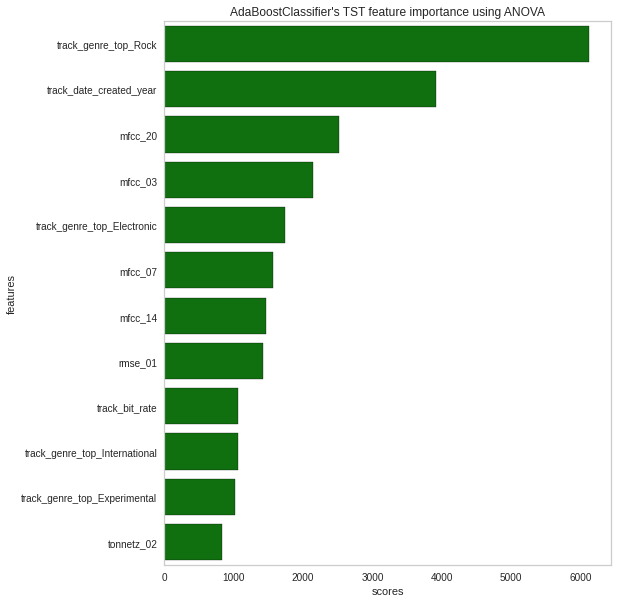

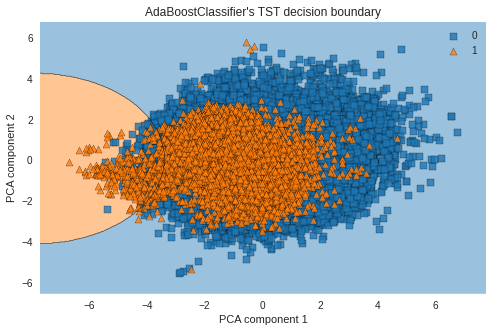

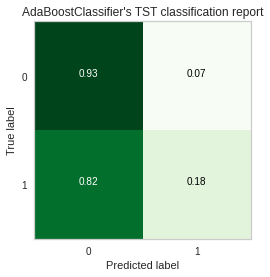

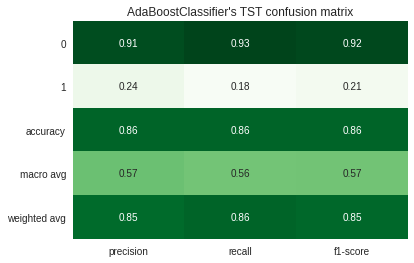

<Figure size 576x360 with 0 Axes>

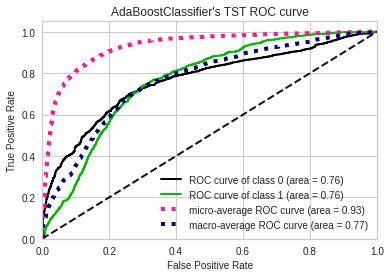

<Figure size 576x360 with 0 Axes>

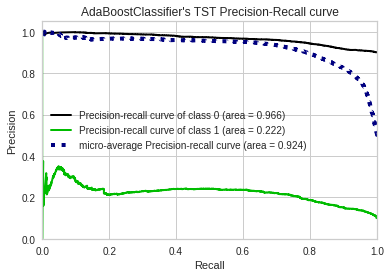

<Figure size 576x360 with 0 Axes>

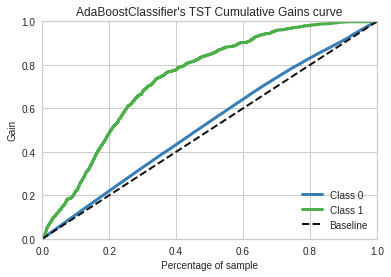

<Figure size 576x360 with 0 Axes>

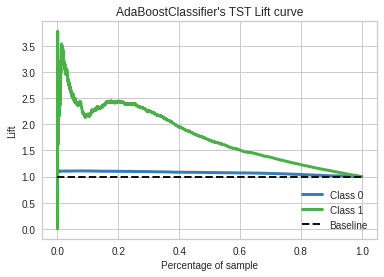

In [20]:
anova_params_tst, anova_tuned_model_tst, anova_y_pred_tst, anova_y_prob_tst, \
                anova_best_features, anova_best_features_scores = \
                                                    grid_search(X_tr=X_tr, 
                                                                y_tr=y_tr,
                                                                X_ts=X_ts, 
                                                                y_ts=y_ts,
                                                                numeric_features=numeric_columns, 
                                                                categorical_features=categoric_columns, 
                                                                discretizer_flag=False, 
                                                                scaler_flag=True, 
                                                                feature_filter_key="anova", 
                                                                feature_flag=False)

<h2>RFE (Recursive Feature Elimination) (wrapper method)</h2>

The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. The RFE method takes the model to be used and the number of required features as input. It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature.

RFE **requires a nested algorithm that is used to provide the feature importance scores**, such
as a decision tree (**feature_importances_ attribute**) or a linear model(**coef_ attribute**).

Feature importance refers to techniques that assign a score to input features based on how
useful they are at predicting a target variable:
- statistical correlation scores;
- coefficients calculated as part of linear models or decision trees;
- permutation importance scores.

<u> RFECV automatic select best k number of features </h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.854 
Best Config: {'rfe__n_features_to_select': 51, 'rfe__estimator': LogisticRegression(max_iter=10000), 'preprocessor__numeric__scaler': MinMaxScaler(), 'model__n_estimators': 150, 'model__learning_rate': 0.1} 


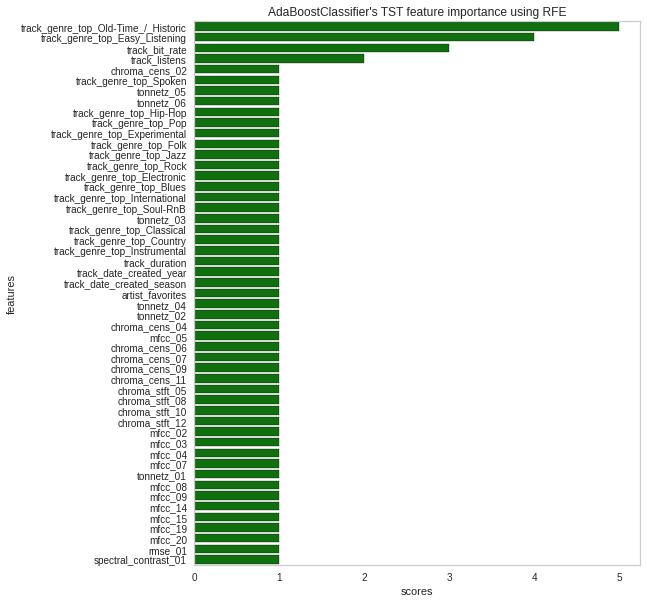

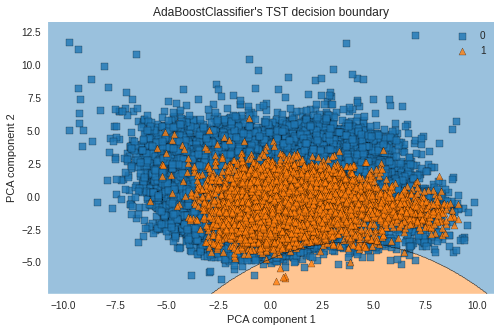

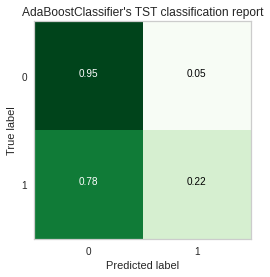

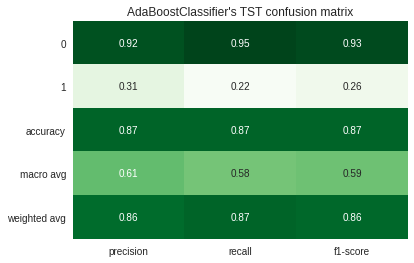

<Figure size 576x360 with 0 Axes>

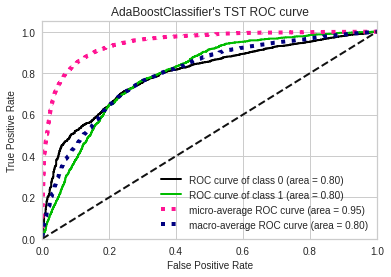

<Figure size 576x360 with 0 Axes>

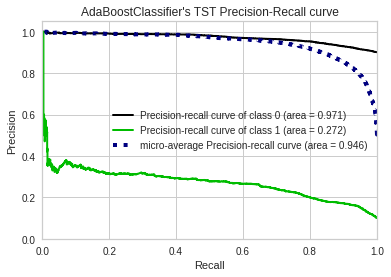

<Figure size 576x360 with 0 Axes>

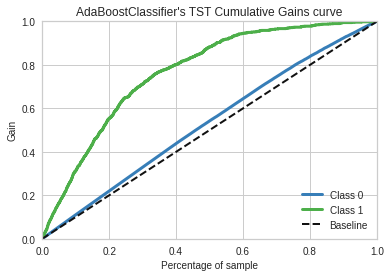

<Figure size 576x360 with 0 Axes>

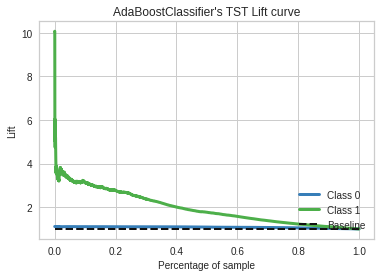

In [21]:
rfe_params_tst, rfe_tuned_model_tst, rfe_y_pred_tst, rfe_y_prob_tst, \
                rfe_best_features, rfe_best_features_scores = \
                                                    grid_search(X_tr=X_tr, 
                                                                y_tr=y_tr,
                                                                X_ts=X_ts, 
                                                                y_ts=y_ts,
                                                                numeric_features=numeric_columns, 
                                                                categorical_features=categoric_columns, 
                                                                discretizer_flag=False, 
                                                                scaler_flag=True, 
                                                                feature_filter_key="rfe", 
                                                                feature_flag=False)

<h2>Variance Threshold</h2>

Since we have many features, we remove all features whose variance doesn’t meet some threshold. By default, VarianceThreshold removes all zero-variance features, i.e. features that have the same value in all samples.

<u>This feature selection algorithm looks only at the features (X), not the desired outputs (y), and can thus be used for unsupervised learning.</u>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.838 
Best Config: {'preprocessor__numeric__scaler': MinMaxScaler(), 'model__n_estimators': 300, 'model__learning_rate': 0.05} 


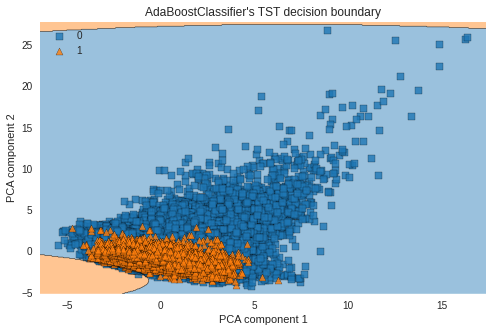

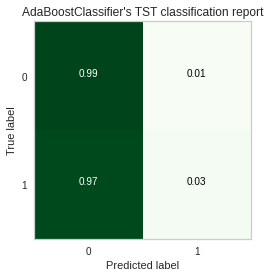

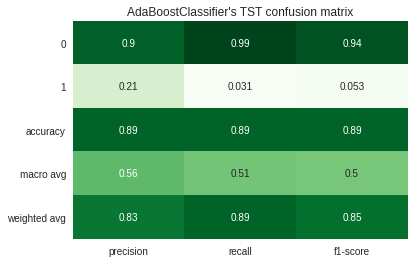

<Figure size 576x360 with 0 Axes>

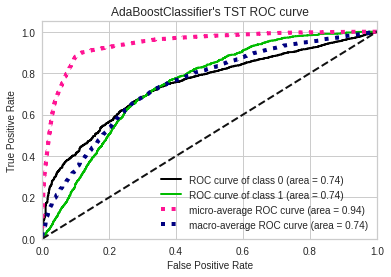

<Figure size 576x360 with 0 Axes>

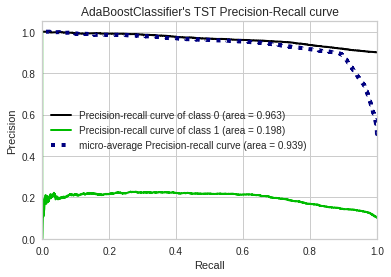

<Figure size 576x360 with 0 Axes>

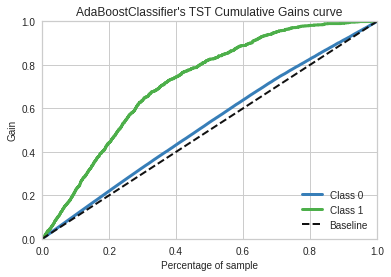

<Figure size 576x360 with 0 Axes>

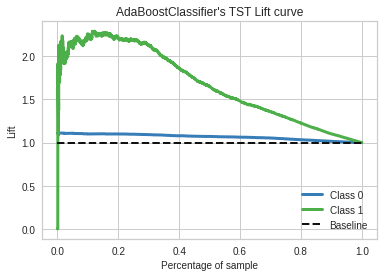

In [22]:
vt_params_tst, vt_tuned_model_tst, vt_y_pred_tst, vt_y_prob_tst, \
                vt_best_features, vt_best_features_scores = \
                                                    grid_search(X_tr=X_tr_vt, 
                                                                y_tr=y_tr,
                                                                X_ts=X_ts_vt, 
                                                                y_ts=y_ts,
                                                                 numeric_features=numeric_columns_vt, 
                                                                categorical_features=categoric_columns_vt, 
                                                                discretizer_flag=False, 
                                                                scaler_flag=True, 
                                                                feature_filter_key="", 
                                                                feature_flag=False)

<h2> Test curves </h2>

In [23]:
def draw_multiple_roc_curves(global_info, model_names, v_or_t_flag):
    # draw_roc_auc
    plt.figure(figsize=(8, 5))
    fprs = []
    tprs = []
    labels = []
    for model_name in global_info.keys():
        fpr = global_info[str(model_name)]["fpr"]
        tpr = global_info[str(model_name)]["tpr"]
        roc_auc = global_info[str(model_name)]["roc"] 
        label = '%s model=%0.4f' % (model_name, roc_auc)
        
        fprs.append(fpr)
        tprs.append(tpr)
        labels.append(label)
    
        # plt.plot(fpr, tpr, label='%s model=%0.4f' % (model_name, roc_auc))
        plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--', color="k", label='No-skilled model=0.5000') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="lower right", title="Weighted AUC", frameon=True)
    plt.title("%s' %s ROC-curve" % (model_names, v_or_t_flag))
    plt.show()

In [24]:
from sklearn.metrics import auc, roc_curve, roc_auc_score 

def get_roc_curve_and_roc_auc_score(y_tst, y_prd, curr_model_name, global_info):
    fpr, tpr, thresholds = roc_curve(y_tst, y_prd)
    roc = roc_auc_score(y_tst, y_prd, average="weighted")
    
    global_info[str(curr_model_name)]["fpr"] = fpr
    global_info[str(curr_model_name)]["tpr"] = tpr
    global_info[str(curr_model_name)]["roc"] = roc
    
    return global_info

In [25]:
global_info = {}
global_info["Plain"] = {}
global_info["ANOVA"] = {}
global_info["RFE"] = {}
global_info["VarianceThreshold"] = {}

global_info = get_roc_curve_and_roc_auc_score(y_test.values.ravel(), y_prob_tst[:, 1], "Plain", global_info)
global_info = get_roc_curve_and_roc_auc_score(y_test.values.ravel(), anova_y_prob_tst[:, 1], "ANOVA", global_info)
global_info = get_roc_curve_and_roc_auc_score(y_test.values.ravel(), rfe_y_prob_tst[:, 1], "RFE", global_info)
global_info = get_roc_curve_and_roc_auc_score(y_test.values.ravel(), vt_y_prob_tst[:, 1], "VarianceThreshold", global_info)

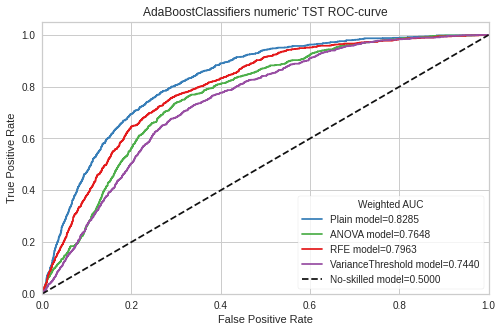

In [26]:
draw_multiple_roc_curves(global_info, model_name + "s numeric" , v_or_t_flag)

<h2>Learning curves </h2>

This plotting is done at the end of the notebook, beacuse for some reason yellowbrick library overwrite scikitplot.

<h6>Saving best model on file</h6>

In [29]:
import pickle

model_info = {'model_name': 'Plain',
              'params': params_tst,
              'tuned_model': tuned_model_tst,
              'y_pred': y_pred_tst,
              'y_prob': y_prob_tst,
              'best_features': best_features,
              'best_features_scores': best_features_scores
             }

with open('pickle/adaboost_' + model_name + '.pickle', 'wb') as handle:
    pickle.dump(model_info, handle, protocol=pickle.HIGHEST_PROTOCOL)